<H1>IMPORTING LIB</H1>

In [5]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
df=pd.read_csv("../final_dataset2.csv")
df

text sentiment
0                     I`d have responded, if I were going   neutral
1           Sooo SAD I will miss you here in San Diego!!!  negative
2                               my boss is bullying me...  negative
3                          what interview! leave me alone  negative
4        Sons of ****, why couldn`t they put them on t...  negative
...                                                   ...       ...
101470  Just realized that the Windows partition of my...  positive
101471  Just realized that my Mac window partition is ...  positive
101472  Just realized the windows partition of my Mac ...  positive
101473  Just realized between the windows partition of...  positive
101474  Just like the windows partition of my Mac is l...  positive

[101475 rows x 2 columns]

In [7]:
df.shape

(101475, 2)

<h1>PREPROCESSING</H1>

In [8]:
import preprocessor as pre

In [9]:
pr=pre.Preprocessor()

c:\Users\ganes\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

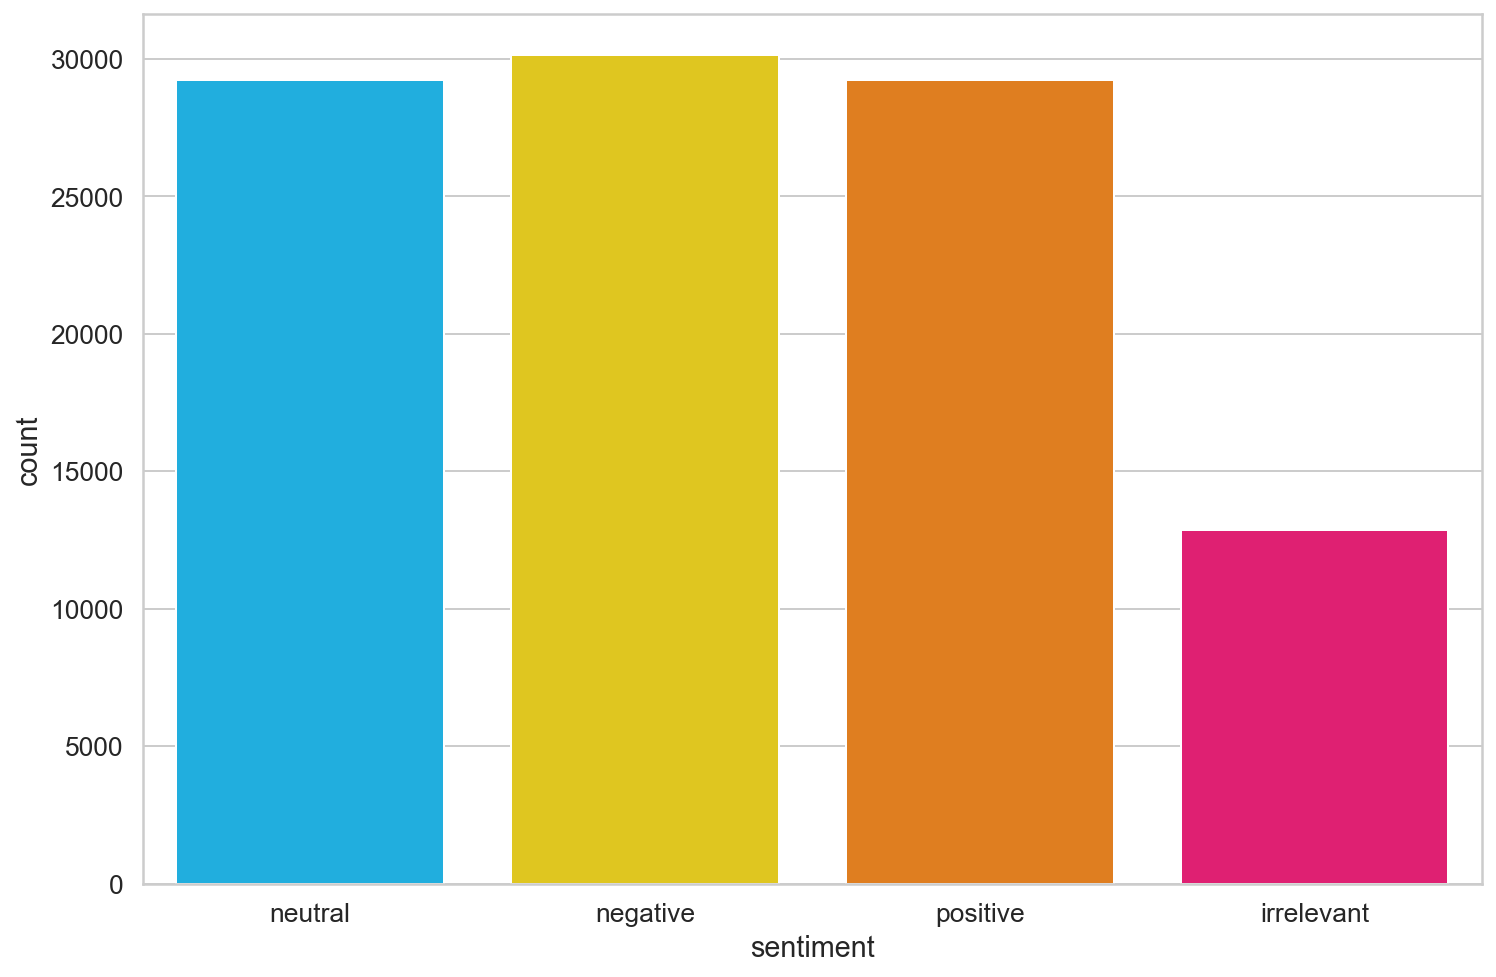

In [10]:
sns.countplot(df.sentiment)

In [11]:
df=df[df.sentiment!='irrelevant']

c:\Users\ganes\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

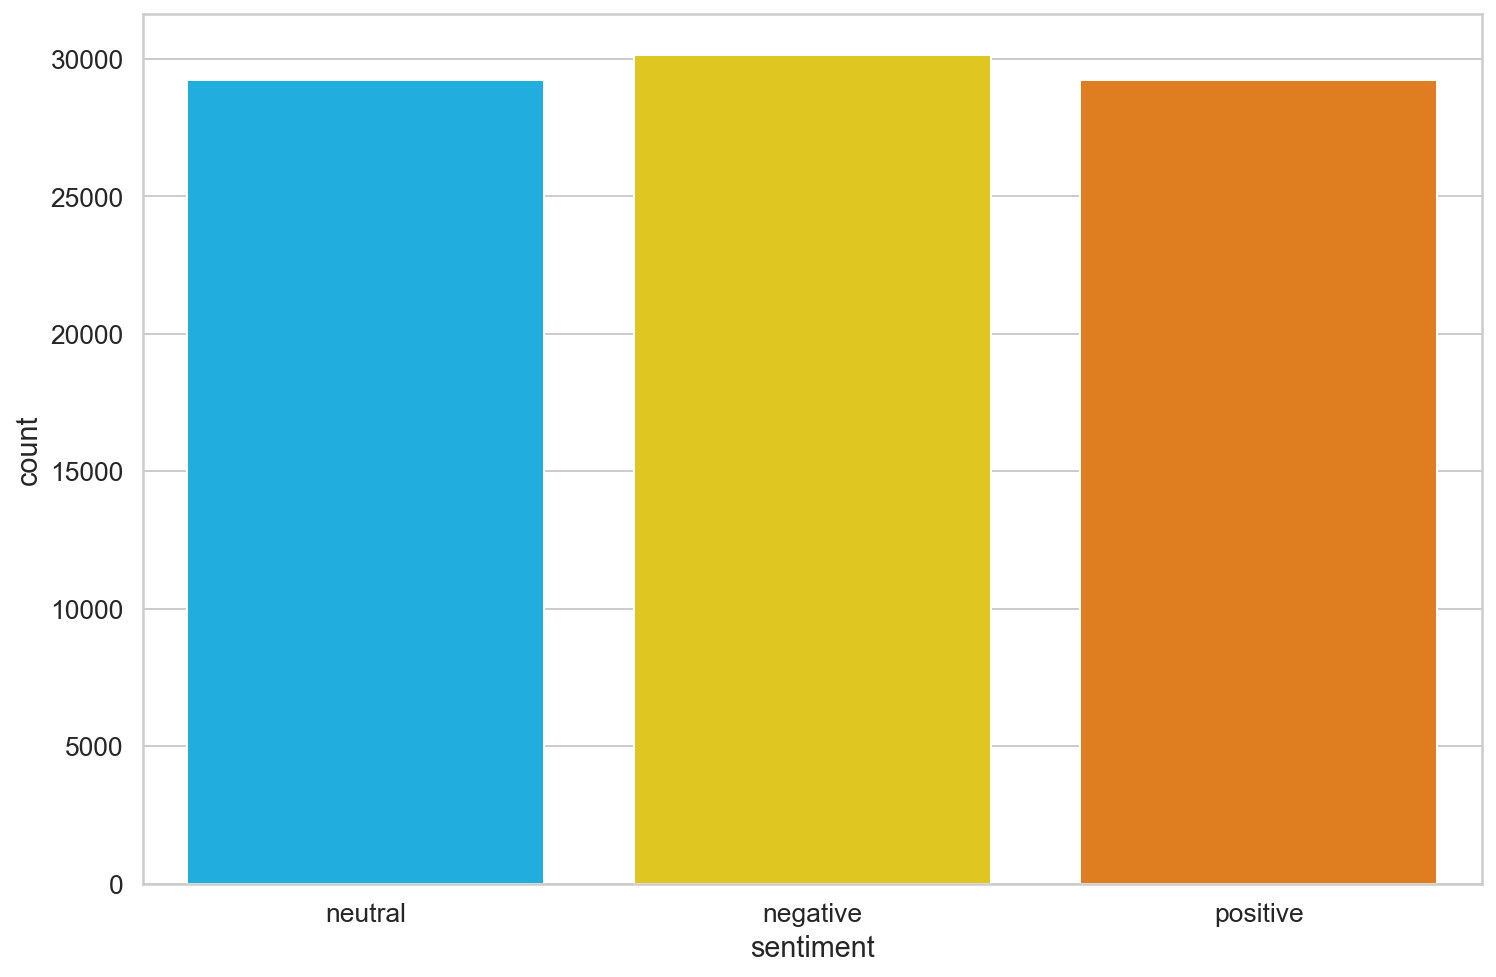

In [12]:
sns.countplot(df.sentiment)

In [22]:
df.text=df.text.apply(lambda x:pr.call_all_func(x))

C:\Users\ganes\AppData\Local\Temp\ipykernel_23048\3383829538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.text=df.text.apply(lambda x:pr.call_all_func(x))


In [23]:
df

text sentiment
0                       Id have responded if I were going   neutral
1              Sooo SAD I will miss you here in San Diego  negative
2                                  my boss is bullying me  negative
3                           what interview leave me alone  negative
4       Sons of why couldnt they put them on the relea...  negative
...                                                   ...       ...
101470  Just realized that the Windows partition of my...  positive
101471  Just realized that my Mac window partition is ...  positive
101472  Just realized the windows partition of my Mac ...  positive
101473  Just realized between the windows partition of...  positive
101474  Just like the windows partition of my Mac is l...  positive

[88600 rows x 2 columns]

In [13]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [14]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [15]:
tokenizer.sep_token_id

102

In [16]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [17]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [18]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [19]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask'][0]

32


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [24]:
for i in df.text:
    print(i)

Id have responded if I were going
Sooo SAD I will miss you here in San Diego
my boss is bullying me
what interview leave me alone
Sons of why couldnt they put them on the releases we already bought
some shameless plugging for the best Rangers forum on earth
2am feedings for the baby are fun when he is all smiles and coos
Soooo high
Both of you
Journey Wow u just became cooler hehe is that possible
as much as i love to be hopeful i reckon the chances are minimal P im never gonna get my cake and stuff
I really really like the song Love Story by Taylor Swift
My Sharpie is running DANGERously low on ink
i want to go to music tonight but i lost my voice
test test from the LG enV2
Uh oh I am sunburned
Sok trying to plot alternatives as we speak sigh
ive been sick for the past few days and thus my hair looks wierd if i didnt have a hat on it would look
is back home now gonna miss every one
Hes just not that into you
oh Marly Im so sorry I hope you find her soon <3 <3
Playing Ghost Online is r